<a href="https://colab.research.google.com/github/Aranagut/Tejaswini_INFO5502_Spring2022/blob/main/lab_assignment_06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## The sixth Lab-assignment (03/24/2022, 50 points in total)

The purpose of this exercise is to build a simple predicition model which can helpyou understand the workflow of machine learning. 

### Task Decription 

The goal of this assignment is to predict bike share use, given the hour, day, and information about the weather. Companies like Divvy try to predict how much demand there will be for bikes on any given day to allocate resources to redistribute bikes so that, ideally, very few bike stations are ever full (when you can’t park your bike) or empty (when you can’t pick up a bike if you want to).

The data (link: https://github.com/unt-iialab/info5502-spring2022/tree/main/datasets/lab_assignment_06) in Github provides detailed information on the data set and necessary downloads.

### Data Description

You are provided hourly rental data spanning two years (link: https://github.com/unt-iialab/info5502-spring2022/tree/main/datasets/lab_assignment_06). For this task, the training set is comprised of the first 16 days of each month, while the test set is the 17-19th day of the month. You must predict the total count of bikes rented during each hour covered by the test set, using only information available prior to the rental period. That is, predict "count" without using "count" or its components "casual" and "registered".

Data Fields

datetime - hourly date + timestamp

season - 1 = spring, 2 = summer, 3 = fall, 4 = winter

holiday - whether the day is considered a holiday

workingday - whether the day is neither a weekend nor holiday

weather -

1 - Clear, Few clouds, Partly cloudy, Partly cloudy

2 - Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist

3 - Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds

4 - Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

temp - temperature in Celsius

atemp - "feels like" temperature in Celsius

humidity - relative humidity

windspeed - wind speed

casual - number of non-registered user rentals initiated

registered - number of registered user rentals initiated

count - number of total rentals

### Output

Submission Format

Your output (a separate file) must have a header line and should be structured in the following format:

 datetime,count
 
 2011-01-20 00:00:00,0 
 
 2011-01-20 01:00:00,0
 
 2011-01-20 02:00:00,0
 
 ...
 
The tutorial code should demonstrate how to generate such a file from a very simple prediction model. Note, these prediction are to be done on the test file under the data tab, where you do not know the actual count, and should match the rows of the test file in count and order.

Your predictions should be compared to the ground truth information (sample_prediction.csv). Score are calculated using Root Mean Squared Error (RMSE).

### Tips

●	Add features: Pick columns/features from the data you already have. Or make a new feature from the ones you have. For example, the tutorial makes ‘hour’ from the datetime stamp, which seemed very useful. How about ‘month’?

●	Model selection: Try different models. Make sure they are regression models rather than classification models. Tip: random forest regression is a good, all around modeling strategy on complicated data sets.

●	Model tuning: Almost all regression models have parameters to tune (“hyperparameters”). E.g. polynomial regression has the degree of the polynomial (n = 1 for a line, n=2 for a quadratic fit, n=3 for a cubic fit…). Generally, one extreme makes the model too simple (e.g. a line for a curved set of points) and the other extreme makes the model overfit/be too complex, and usually the right choice is in between. For some models it is obvious what to tune (e.g. k for k nearest neighbors regression) and some don’t need much tuning with defaults that often work well. e.g. try changing the number of trees used in the random forest model!

●	Cross validation: The tutorial has a simple way of separating training and test data, however, there are better ways of splitting training and test data. Look into cross validation techniques, which are more reliable than an arbitrary split of training and test data.

●	Separate models for ...: Notice that count comes from just adding casual riders and registered riders. However, what if these two types of riders acted very differently? It might make sense to make two separate models and just add the results of both models together. This is also true for any subsets of your data that may behave wildly differently (e.g. create a separate model for each season?)

### Your code

In [ ]:
### You code here:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from numpy.random import shuffle
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import LinearSVR

get_ipython().run_line_magic('matplotlib', 'inline')

In [ ]:
traindata_frame=pd.read_csv("/content/drive/MyDrive/train_luc.csv");
traindata_frame.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,9174.000000,9174.000000,9174.000000,9174.000000,9174.000000,9174.000000,9174.000000,9174.000000,9174.000000,9174.000000,9174.000000
mean,2.505559,0.031284,0.678875,1.414868,20.130401,23.578433,61.715064,12.737931,35.713647,154.868106,190.581753
std,1.116618,0.174094,0.466934,0.635363,7.940504,8.617957,19.401829,8.199027,49.667738,150.981155,181.011530
min,1.000000,0.000000,0.000000,1.000000,0.820000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.940000,16.665000,46.000000,7.001500,4.000000,35.000000,41.000000
50%,3.000000,0.000000,1.000000,1.000000,20.500000,24.240000,61.000000,11.001400,16.000000,117.000000,144.000000
75%,4.000000,0.000000,1.000000,2.000000,27.060000,31.060000,78.000000,16.997900,48.000000,222.000000,282.000000
max,4.000000,1.000000,1.000000,4.000000,41.000000,45.455000,100.000000,56.996900,362.000000,886.000000,977.000000


In [ ]:
testdata_frame=pd.read_csv("/content/drive/MyDrive/test_luc.csv");
testdata_frame.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
count,1712.000000,1712.000000,1712.000000,1712.000000,1712.000000,1712.000000,1712.000000,1712.000000
mean,2.512266,0.014019,0.691589,1.437500,20.769182,24.065832,62.804907,13.128763
std,1.114104,0.117602,0.461972,0.625445,6.916677,7.650085,18.360263,7.971457
min,1.000000,0.000000,0.000000,1.000000,4.920000,6.060000,8.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,15.580000,19.695000,49.000000,7.001500
50%,3.000000,0.000000,1.000000,1.000000,21.320000,25.000000,64.000000,12.998000
75%,4.000000,0.000000,1.000000,2.000000,25.420000,30.305000,77.000000,16.997900
max,4.000000,1.000000,1.000000,3.000000,38.540000,43.940000,100.000000,50.002100


In [ ]:
def month_of_year(dt):
    return datetime.strptime(dt,"%Y-%m-%d %H:%M:%S").month

def hour_of_day(dt):
    return datetime.strptime(dt, "%Y-%m-%d %H:%M:%S").time().hour

In [ ]:
traindata_frame['hour'] = train_data_frame['datetime'].map(hour_of_day)
traindata_frame['month'] = train_data_frame['datetime'].map(month_of_year)


In [ ]:
hours = numpy.unique(traindata_frame['hour'])
print("hours :",hours)

hours : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


In [ ]:
print("\nTotal number of samples are", traindata_frame.shape[0], "\n" "Total number of features are", traindata_frame.shape[1], "\n")

traindata_frame.head()


Total number of samples are 9174 
Total number of features are 14 



,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,month
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0,1
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2,1
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3,1
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4,1


hours: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


Text(0.5, 1.0, 'Bikes use over 2 years')

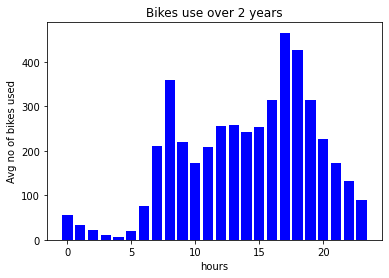

In [ ]:
noof_hours = np.unique(traindata_frame['hour'])
print("hours:",noof_hours)
noof_hours_mean = {}

for p in noof_hours:
    temp_df = traindata_frame.loc[traindata_frame['hour'] == p]
    noof_hours_mean[p] = temp_df['count'].mean()

plt.bar(noof_hours,[noof_hours_mean[p] for p in noof_hours],color="blue")
plt.xlabel("hours")
plt.ylabel("Avg no of bikes used")
plt.title("Bikes use over 2 years")

months: [ 1  2  3  4  5  6  7  8  9 10 11 12]


Text(0.5, 1.0, 'Bike use over 2 years')

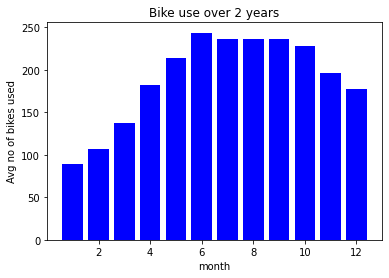

In [ ]:
noof_months = np.unique(traindata_frame['month'])
print("months:",noof_months)
noof_months_mean = {}
for p in noof_months:
    temp_df = traindata_frame.loc[traindata_frame['month'] == p]
    noof_months_mean[p] = temp_df['count'].mean()
plt.bar(noof_months,[noof_months_mean[p] for p in noof_months],color="blue")
plt.xlabel("month")
plt.ylabel("Avg no of bikes used")
plt.title("Bike use over 2 years")

In [ ]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
col = ['hour','month','season']
X = traindata_frame[col]
X = preprocessing.scale(X) 
Y = traindata_frame['count'].values
X_train1,X_test1,Y_train1,Y_test1 = train_test_split(X,Y,test_size=0.3,random_state=0)

In [ ]:
RFG.fit(X_train1, Y_train1)
pred_count = RFG.predict(X_test)
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

RMS_value = np.sqrt(mean_squared_error(Y_test,pred_count))
print("RMS error:",RMS_value)

RMS error: 113.87992817602971


In [ ]:
from sklearn.metrics import r2_score
print(r2_score(Y_test,pred_count))

0.6208910872196228


In [ ]:
for i in ['season', 'weather', 'holiday', 'workingday']:
    data[i] = data[i].astype('object')

# Dummification of the below columns in the dataset
one_hot_df = pd.get_dummies(data[['season', 'holiday', 'workingday', 'weather']])
# we drop unnecessary columns
X = data.drop(['datetime','casual','registered', 'season', 'holiday', 'workingday', 'weather', 'day', 'count'], axis=1)
# we append the dummies data to the original data
X = X.join(one_hot_df)
# target column
y = data['count']

from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
# We split the dataset using Kfold cross validation
kfold = KFold(n_splits=5, shuffle=True, random_state=None)
for train, test in kfold.split(data):
    print('train: %s, test: %s' % (train, test))

train: [   0    1    4 ... 9170 9172 9173], test: [   2    3    8 ... 9165 9166 9171]
train: [   0    2    3 ... 9171 9172 9173], test: [   1    5   16 ... 9163 9168 9169]
train: [   1    2    3 ... 9169 9171 9173], test: [   0    6    7 ... 9160 9170 9172]
train: [   0    1    2 ... 9171 9172 9173], test: [  11   21   22 ... 9162 9164 9167]
train: [   0    1    2 ... 9170 9171 9172], test: [   4   13   15 ... 9147 9148 9173]


In [ ]:
# load the test dataset
testdata = pd.read_csv("https://raw.githubusercontent.com/unt-iialab/info5502-spring2022/main/datasets/lab_assignment_06/test_luc.csv")
# change the dataset type to datatime
testdata['datetime'] = pd.to_datetime(testdata.datetime)
# we extract the hour and month
testdata['hour'] = testdata['datetime'].dt.hour
testdata['month'] = testdata['datetime'].dt.month
# convert the following columns datatype to categorical
for i in ['season', 'weather', 'holiday', 'workingday']:
    testdata[i] = testdata[i].astype('object')

one_hot_test_data = pd.get_dummies(testdata[['season', 'holiday', 'workingday', 'weather']])
testdata = testdata.drop(['datetime', 'season', 'holiday', 'workingday', 'weather'], axis=1)
testdata = testdata.join(one_hot_test_data)

# test data doesn't have weather category 4
# we append that column
testdata['weather_4'] = 0

print(testdata.columns)
print(X.columns)

Index(['temp', 'atemp', 'humidity', 'windspeed', 'hour', 'month', 'season_1',
       'season_2', 'season_3', 'season_4', 'holiday_0', 'holiday_1',
       'workingday_0', 'workingday_1', 'weather_1', 'weather_2', 'weather_3',
       'weather_4'],
      dtype='object')
Index(['temp', 'atemp', 'humidity', 'windspeed', 'hour', 'month', 'season_1',
       'season_2', 'season_3', 'season_4', 'holiday_0', 'holiday_1',
       'workingday_0', 'workingday_1', 'weather_1', 'weather_2', 'weather_3',
       'weather_4'],
      dtype='object')


In [ ]:
# Applying Linear Regression to find the customers count of Rentals
lr = LinearRegression()
lr.fit(X.iloc[train], y.iloc[train])
lr_ypred = lr.predict(X.iloc[test])
# finding mean square error
mse = mean_squared_error(y.iloc[test], lr_ypred)
print("RMSE:", np.sqrt(mse))
# finding R2 Score
r_squared = r2_score(y.iloc[test], lr_ypred)
print("R2 Score:", r_squared)
# predicting values
lr_test_pred = lr.predict(testdata)
lr_test_pred

RMSE: 142.53509455067228
R2 Score: 0.3516135170214941


array([ 13.5175252 ,  25.58923817,  25.74038113, ..., 255.21754349,
       267.04176588, 259.17742621])

In [ ]:
from sklearn.tree import DecisionTreeRegressor
# Using Decision Tree Regressor model to find the count values
dtr = DecisionTreeRegressor(random_state=211)
dtr.fit(X.iloc[train], y.iloc[train])
dtr_ypred = dtr.predict(X.iloc[test])
mse = mean_squared_error(y.iloc[test], dtr_ypred)
print("RMSE:", np.sqrt(mse))
r_squared = r2_score(y.iloc[test], dtr_ypred)
print("R2 Score:", r_squared)
dtr_test_pred = dtr.predict(testdata)
dtr_test_pred

RMSE: 89.34629994615116
R2 Score: 0.7452328198811251


array([ 42.,  42.,  43., ..., 162., 163.,  82.])

In [ ]:
from sklearn.ensemble import RandomForestRegressor
# using Random Forest Regressor to find the count values
rfr = RandomForestRegressor(random_state = 211)
rfr.fit(X.iloc[train], y.iloc[train])
rfr_ypred = rfr.predict(X.iloc[test])
mse = mean_squared_error(y.iloc[test], rfr_ypred)
print("RMSE:", np.sqrt(mse))
r_squared = r2_score(y.iloc[test], rfr_ypred)
print("R2 Score: ", r_squared)
rfr_test_pred = rfr.predict(testdata)
rfr_test_pred

RMSE: 67.13486269064985
R2 Score:  0.8561577240279914


array([ 48.7 ,  30.76,  36.72, ..., 153.94, 146.83, 100.2 ])

In [ ]:
testdata = pd.read_csv("https://raw.githubusercontent.com/unt-iialab/info5502-spring2022/main/datasets/lab_assignment_06/test_luc.csv")
testdata['count'] = rfr_test_pred

In [ ]:
testdata[['datetime', 'count']]

,datetime,count
0,2011-01-17 00:00:00,48.70
1,2011-01-17 01:00:00,30.76
2,2011-01-17 02:00:00,36.72
3,2011-01-17 03:00:00,13.63
4,2011-01-17 04:00:00,6.74
...,...,...
1707,2012-12-19 19:00:00,313.86
1708,2012-12-19 20:00:00,231.22
1709,2012-12-19 21:00:00,153.94
1710,2012-12-19 22:00:00,146.83


In [ ]:
testdata = pd.read_csv('/content/drive/MyDrive/test_luc.csv', header=0)
print("\nNumber of samples:",testdata.shape[0] ,"and number of features:",testdata.shape[1],"\n")
testdata['hour'] = testdata['datetime'].map(hour_of_day)
testdata['month'] = testdata['datetime'].map(month_of_year)
testdata.head()
RFG.fit( traindata_frame[col], traindata_frame['count'])
pred_count = RFG.predict(testdata[col])
testdata['count'] = pred_count
testdata = testdata[['datetime','count']].to_csv('TejaswiniA_LA6.csv', 
    index=False, header=True)
print("Prediction complete. Saved as TejaswiniA_LA6.csv")


Number of samples: 1712 and number of features: 9 

Prediction complete. Saved as TejaswiniA_LA6.csv
